<p style="font-size:32px; font-weight: bolder; text-align: center"> Multiple time stepping <br/> and ring-polymer contraction </p>
<p style="text-align: center"><i> authored by: <a href="mailto:michele.ceriotti@gmail.com"> Michele Ceriotti </a></i></p>

This notebook provides an introduction to two closely-related techniques, that are geared towards reducing the cost of calculations by separating slowly-varying (and computationally-expensive) components of the potential energy from the fast-varying (and hopefully cheaper) ones.

The first is named _multiple time stepping_, and is a well-established technique to avoid evaluating the slowly-varying components at every time step of a MD simulation. It was first introduced in [M. Tuckerman, B. J. Berne, and G. J. Martyna, JCP 97(3), 1990 (1992)](https://doi.org/10.1063/1.463137) and can be applied to classical simulations - typically to avoid the evaluation of long-range electrostatics in classical potentials. 

The second is named _ring polymer contraction_, first introduced in [T. E. Markland and D. E. Manolopoulos, JCP 129(2), 024105 (2008)](https://doi.org/10.1063/1.2953308) can be seen as performing a similar simplification _in imaginary time_, evaluating the expensive part of the potential on a smaller number of PI replicas. 

The techniques can be combined, which reduces even further the computational effort. This dual approach, which was introduced in [V. Kapil, J. VandeVondele, and M. Ceriotti, JCP 144(5), 054111 (2016)](https://doi.org/10.1063/1.4941091) and [O. Marsalek and T. E. Markland, JCP 144(5), (2016)](https://doi.org/10.1063/1.4941093), is the one that we will discuss here, allowing us to showcase two advanced features of i-PI. It is worth stressing that MTS and/or RPC can be used very conveniently together with machine-learning potentials (see e.g. [V. Kapil, J. Behler, and M. Ceriotti, JCP 145(23), 234103 (2016)](https://doi.org/10.1063/1.4971438) for an early application). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ase, ase.io
import chemiscope
import pimdmooc
import warnings
pimdmooc.add_ipi_paths()

# Multiple time stepping in real and imaginary time

The core underlying assumption in these techniques is that the potential can be decomposed into a short-range/fast-varying/computationally-cheap part $V_\mathrm{sr}$ and a long-range/slow-varying/computationally-expensive part $V_\mathrm{lr}$.  This is usually written as $V=V_\mathrm{sr} +V_\mathrm{lr}$, although in many cases $V_\mathrm{sr}$ is a cheap approximation of the potential, and $V_\mathrm{lr}$ is taken to be the difference between this potential and the full one. 

<div align="center">
  <img style='width:40%; test-align:center' src="figures/pimd-mts-pots.png" alt="A smooth and rough potential components combine to form the total potential energy function usef in a simulation."/>
</div>

Either way, the idea is that it should be possible to compute the slowly-varying component using a coarser time grid, as shown in the figure. 

The way this is realized in practice is by splitting the propagation of Hamilton's equations into an inner loop that uses the fast/cheap force, and an outer loop that applies the slow force, using a larger time step (and therefore giving a larger "kick").  

<div align="center">
  <img style='width:40%; test-align:center' src="figures/pimd-mts-integrator.png" alt="Schematic representation of the application of slow and fast forces in a multiple time step molecular dynamics algorithm"/>
</div>

The scheme is exemplified by the figure above. Using a 1D notation for simplicity, the MTS algorithm reads like

$$
\begin{split}
&p\leftarrow p + f_\mathrm{lr} dt/2 \\
&\left.
\begin{split}
&p\leftarrow p + f_\mathrm{sr} dt/2M \\
&q\leftarrow q + p\, dt/M \\
&p\leftarrow p + f_\mathrm{sr} dt/2M \\
\end{split} 
\right\} M\ \mathrm{times}\\
&p\leftarrow p + f_\mathrm{lr} dt/2 \\
\end{split}
$$

which can (and usually is) complemented by aggressive thermostatting, that helps stabilize the dynamics in the limit of large $M$. See e.g. [J. A. Morrone, T. E. Markland, M. Ceriotti, and B. J. Berne, JCP 134(1), 14103 (2011)](https://doi.org/10.1063/1.3518369) for a discussion of how thermostatting can help in this context. 

The idea behind ring-polymer contraction is very similar: it is unnecessary to evaluate on a very fine-grained discretization of the path integral components of the potential that are slowly-varying. 

<div align="center">
  <img style='width:40%; test-align:center' src="figures/pimd-mts-rpc.png" alt="A visualization of how only the fast-varying part of the potential requires a high-resolution discretization of the ring polymer."/> &nbsp; &nbsp;&nbsp;&nbsp; <img style='width:20%; test-align:center' src="figures/rpc-4.png" alt="Fourier interpolation of the positions of the beads in a 2D ring polymer."/>
</div>

As shown in the right-hand panel above, ring-polymer contraction is realized by computing a Fourier interpolation of the bead positions, $\tilde{\mathbf{q}}^{(k)}$, and then evaluating the total potential that enters the ring-polymer Hamiltonian as 

$$
V(\mathbf{q}) = \sum_{k=1}^P V_\mathrm{sr}(\mathbf{q}^{(k)}) + \frac{P}{P'}  \sum_{k=1}^{P'} V_\mathrm{lr}(\tilde{\mathbf{q}}^{(k)})
$$

where $P$ and $P'$ indicate the full and contracted discretizations of the path. 

<a id="setting-up"> </a>

# A reference calculation using PIGLET

First, let's run a reference calculation without RPC or MTS. These calculations will be done for the q-TIP4P/f water model, [S. Habershon, T. E. Markland, and D. E. Manolopoulos, JCP 131(2), 24501 (2009)](https://doi.org/10.1063/1.3167790), that contains a Morse-potential anharmonic intra-molecular potential, and an inter-molecular potential based on a Lennard-Jones term and a 4-point electrostatic model (the venerable TIP4P idea).  It is fitted to reproduce experimental properties of water _when performing PIMD calculations_ and it captures nicely several subtle effects while being cheap and easy-to-implement. Easy enough to have it in the built-in driver distributed with i-PI.

The input for this run is `h2o_pimd.xml`, and we will use the `-m qtip4pf` option of `i-pi-driver` to compute the appropriate potential. The simulation involves a respectable box containing 216 water molecules, and is run with 8 beads and a _PIGLET_ thermostat (cf. [M. Ceriotti and D. E. Manolopoulos, Phys. Rev. Lett. 109(10), 100604 (2012)](https://doi.org/10.1103/PhysRevLett.109.100604). For simplicity, we use the constant-volume _NVT_ ensemble, but you can easily modify the input to perform constant-pressure simulations. 

The important parts of the simulation - which we will modify to run a RPC/MTS simulation - are the definition of the forcefield socket

In [2]:
!sed -n '8,10p' h2o_pimd.xml

  <ffsocket mode='unix' name='qtip4pf' pbc='false'>
      <address>qtip4pf</address>
  </ffsocket>


The important parts of the simulation - which we will modify to run a RPC/MTS simulation - are the definition of the forcefield socket, with the corresponding force definition

In [3]:
!sed -n '8,10p' h2o_pimd.xml
print("\n[...]\n")
!sed -n '16,18p' h2o_pimd.xml

  <ffsocket mode='unix' name='qtip4pf' pbc='false'>
      <address>qtip4pf</address>
  </ffsocket>

[...]

    <forces>
      <force forcefield='qtip4pf'/>
    </forces>


... the definitin of the number of beads

In [4]:
!sed -n '12p' h2o_pimd.xml

    <initialize nbeads='8'>


... and the time step

In [5]:
!sed -n '24p' h2o_pimd.xml

          <timestep units='femtosecond'> 0.5 </timestep>


The horrendous `<thermostat>` section contains PIGLET parameters generated using the [GLE4MD website](https://gle4md.org/index.html?page=matrix&kind=piglet&centroid=kh_8-4&cw0=4000&ucw0=cm1&nbeads=8&temp=300&utemp=k&parset=20_8_t&outmode=ipi&aunits=ps&cunits=k).

We are going to launch i-PI from here, and put it in background and detach the processes from the jupyter instance, so we can continue with the notebook. **DON'T RE-RUN THE CELL BEFORE THE CALCULATION HAS FINISHED** to avoid conflicts and file overwriting. 

In [12]:
%%bash --bg
#cd 02-rpc_mts
PYTHONUNBUFFERED=1 i-pi h2o_pimd.xml &> log.pimd &
sleep 5
for i in `seq 1 4`; do
  i-pi-driver -u -a qtip4pf -m qtip4pf -v &> log.driver.$i &
done
wait

You can view the log from here, to make sure all is running as it should

In [14]:
!tail -n 20 log.pimd

       </dynamics>
     </motion>
   </system>
 </simulation>
  ---  end input file content  ---
Backup performed: pimd.checkpoint -> #pimd.checkpoint#0#
 @SOCKET:   Client asked for connection from . Now hand-shaking.
 @SOCKET:   Handshaking was successful. Added to the client list.
 @SOCKET:   Client asked for connection from . Now hand-shaking.
 @SOCKET:   Handshaking was successful. Added to the client list.
 @SOCKET:   Client asked for connection from . Now hand-shaking.
 @SOCKET:   Handshaking was successful. Added to the client list.
 @SOCKET:   Client asked for connection from . Now hand-shaking.
 @SOCKET:   Handshaking was successful. Added to the client list.
 # Average timings at MD step       0. t/step: 1.15809e-01
 # Average timings at MD step     100. t/step: 1.21863e-01
 # Average timings at MD step     200. t/step: 1.26507e-01
 !W!  @SOCKET:   Timeout in getforce, trying again!
 # Average timings at MD step     300. t/step: 1.22435e-01
 # Average timings at MD step     

# Multiple time stepping

Let's now run a classical MD simulation, with and without multiple time stepping. We use very conservative parameters and a weak thermostat, to be able to see the difference in time scales between the full and short-range parts of the potential. Let's first run a classical MD for reference. The input file is `h2o_md.xml`, nothing exciting to see there.

In [15]:
%%bash --bg
#cd 02-rpc_mts
PYTHONUNBUFFERED=1 i-pi h2o_md.xml &> log.md &
sleep 5
i-pi-driver -u -a qtip4pf-md -m qtip4pf -v &> log.driver.md

In [17]:
!tail -n 20 log.md

       <force forcefield='qtip4pf'></force>
     </forces>
     <ensemble>
       <temperature units='kelvin'> 300 </temperature>
     </ensemble>
     <motion mode='dynamics'>
       <dynamics mode='nvt'>
           <timestep units='femtosecond'> 0.5 </timestep>
           <thermostat mode="svr">
              <tau units="femtosecond"> 400 </tau>
           </thermostat>
       </dynamics>
     </motion>
   </system>
 </simulation>
  ---  end input file content  ---
Backup performed: md.checkpoint -> #md.checkpoint#0#
 @SOCKET:   Client asked for connection from . Now hand-shaking.
 @SOCKET:   Handshaking was successful. Added to the client list.
 # Average timings at MD step       0. t/step: 5.04866e-02


While this runs, let's have a look at `h2o_mts.xml`, that provides the parameters of the MTS calculation. We define two `ffsocket` sections - one will be used with the `qtip4pf` driver and the other with `qtip4pf-sr`. Note the different names of the sockets (that have to match the `-a` option in the invocation of the driver) and the internal labels that will be referred to in the `<forces>` section. 

In [9]:
!sed -n '8,13p' h2o_mts.xml

  <ffsocket mode='unix' name='qtip4pf' pbc='false'>
      <address>qtip4pf-full</address>
  </ffsocket>
  <ffsocket mode='unix' name='qtip4pf-sr' pbc='false'>
      <address>qtip4pf-sr</address>
  </ffsocket>


Each `<force>` block contains a `<mts_weights>` section. This provides a list of weights that determine which force components are active at each level of the MTS hierarchy. These weights indicate that the smooth part (full minus short-range) is active in the outer loop, and the short-range part is active in the inner loop. Note that the implementation is smart enough to re-use the short-range potential computed in the inner loop, multiplying it with a weight of $-1$ to compute $V_\mathrm{lr}=V-V_\mathrm{sr}$. 

In [10]:
!sed -n '19,26p' h2o_mts.xml

    <forces>
      <force forcefield='qtip4pf'>
              <mts_weights>[1,0]</mts_weights>
      </force>
      <force forcefield='qtip4pf-sr'>
              <mts_weights>[-1,1]</mts_weights>
      </force>
    </forces>


It remains to specify the MTS setup. We use an outer time step of 2 fs (four times the typical time step for room temperature water) and a splitting with `M=4`, so the fast forces are computed every 0.5 fs.

In [11]:
!sed -n '32,33p' h2o_mts.xml

          <timestep units='femtosecond'> 2.0 </timestep>
          <nmts>[1,4]</nmts>


One final detail, is that we print out the two components of the potential. This is achieved adding `pot_component{units}(idx)` to the `<properties>` field. The index corresponds to the order by which the `<force>` components are specified in the `<forces>` list. 
_NB: the time step in i-PI is the outer time step, so it is not possible to access directly the value of the potential for intermediate inner steps_

In [12]:
!sed -n '3p' h2o_mts.xml

    <properties filename='out' stride='1'> [step, time{picosecond}, conserved{electronvolt}, temperature{kelvin}, potential{electronvolt}, kinetic_md{electronvolt}, pressure_md{megapascal}, pot_component{electronvolt}(0), pot_component{electronvolt}(1) ] </properties>


Let's get the simulation going. Notice that we need two drivers, computing the short and full potentials, connected to the proper `<ffsocket>` on the i-PI side

In [13]:
%%bash --bg
#cd 02-rpc_mts
PYTHONUNBUFFERED=1 i-pi h2o_mts.xml &> log.mts &
sleep 5
i-pi-driver -u -a qtip4pf-mts-full -m qtip4pf -v &> log.driver.full &
i-pi-driver -u -a qtip4pf-mts-sr -m qtip4pf-sr -v &> log.driver.sr &
wait

In [42]:
!tail -n 20 log.mts

 # Average timings at MD step    1400. t/step: 1.19975e-01
 # Average timings at MD step    1500. t/step: 1.31706e-01
 # Average timings at MD step    1600. t/step: 1.28293e-01
 # Average timings at MD step    1700. t/step: 1.28247e-01
 # Average timings at MD step    1800. t/step: 1.14503e-01
 # Average timings at MD step    1900. t/step: 1.32380e-01
 # Average timings at MD step    2000. t/step: 1.27554e-01
 !W!  @SOCKET:   Timeout in getforce, trying again!
 # Average timings at MD step    2100. t/step: 1.26186e-01
 # Average timings at MD step    2200. t/step: 1.30167e-01
 !W!  @SOCKET:   Timeout in getforce, trying again!
 # Average timings at MD step    2300. t/step: 1.56137e-01
 # Average timings at MD step    2400. t/step: 1.32692e-01
SOFTEXIT CALLED FROM THREAD <_MainThread(MainThread, started 139816104544064)>  @ SIMULATION: Exiting cleanly.
 !W! Soft exit has been requested with message: ' @ SIMULATION: Exiting cleanly.
I-PI reports success. Restartable as is: NO.'. Cleaning

## Analysis of results

Load the trajectories (might have to wait a few minutes for them to be over)

In [18]:
md_output = pimdmooc.read_ipi_output('md.out')
mts_output = pimdmooc.read_ipi_output('mts.out')

We can start looking at the behavior of the two components of the potential. Even though this is hardly the best slow/fast mode splitting (usually one also includes the Lennard-Jones and short-range Coulomb components in $V_\mathrm{sr}$) it is clear that the intra-molecular potential varies much faster than the non-bonded components. Running the whole simulation with a 2 fs time step would lead to major instabilities in the trajectory. 

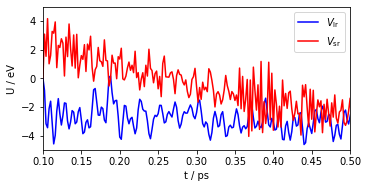

In [19]:
fig, ax = plt.subplots(1,1,constrained_layout=True, figsize=(5,2.5))
ax.plot(mts_output["time"], mts_output["pot_component"]-mts_output["pot_component+"]-
        ( mts_output["pot_component"]-mts_output["pot_component+"])[50], 'b-', label=r"$V_\mathrm{lr}$")
ax.plot(mts_output["time"], mts_output["pot_component+"]-mts_output["pot_component+"][50], 'r-', label=r"$V_\mathrm{sr}$")
ax.set_xlabel("t / ps")
ax.set_ylabel("U / eV")
ax.set_xlim(0.1,0.5)
ax.set_ylim(-5,5)
ax.legend();

The equilibration is slow due to the weak thermostat, but the two trajectories both equilibrate to 300 K. The difference in potential energy is not significant, because of the slow convergence of the potential energy in liquid water.

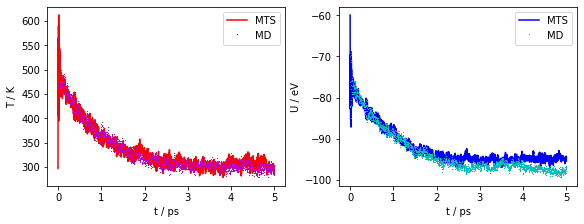

In [45]:
fig, ax = plt.subplots(1,2,constrained_layout=True, figsize=(8,3))
ax[1].plot(mts_output["time"], mts_output["potential"], 'b-', label="MTS")
ax[1].plot(md_output["time"], md_output["potential"], 'c,', label="MD")
ax[1].set_xlabel("t / ps")
ax[1].set_ylabel("U / eV")
ax[0].plot(mts_output["time"], mts_output["temperature"], 'r-', label="MTS")
ax[0].plot(md_output["time"], md_output["temperature"], 'm,', label="MD")
ax[0].set_xlabel("t / ps")
ax[0].set_ylabel("T / K")
ax[0].legend()
ax[1].legend();

# RPC/MTS simulation

Now let's get to the full beast. The input for the RCP/MTS simulation is `h2o_rpc-mts.xml`. The setup is rather subtle, because we will use the F90 driver that implements the full q-TIP4P/f potential (with `-m qtip4pf`) and the intra-molecular part (with `-m qtip4pf-sr`). This means that we will have to compute the slowly-varying part as $V_\mathrm{full}-V_\mathrm{sr}$. Let's look at the key sections in the input file. Much as for the MTS setup, the simulation includes two `ffsocket` sections - one will be used with the `qtip4pf` driver and the other with `qtip4pf-sr`. 

In [19]:
!sed -n '8,13p' h2o_rpc-mts.xml

  <ffsocket mode='unix' name='qtip4pf' pbc='false'>
      <address>qtip4pf-full</address>
  </ffsocket>
  <ffsocket mode='unix' name='qtip4pf-sr' pbc='false'>
      <address>qtip4pf-sr</address>
  </ffsocket>  


The `<forces>` section is where the magic happens. There are three components here.
The first computes a full `qtip4pf` potential, and is computed on a contraction to 2 beads, as indicated by the `nbeads='2'` attribute. 
A second component is also evaluated on a contracted ring polymer, and is used to subtract the short-range component to leave the (smoother) long-range part. This is achieved linking to the `qtip4pf-sr` forcefield, and using the attribute `weight='-1'` to subtract the term from the total potential. 
Finally, there is another `qtip4pf-sr` component, that is evaluated on the full `nbeads='8'` ring polymer. 
The result is a RPC setup in which the smooth (Lennard-Jones + Coulomb) part of the potential is contracted on 2 replicas, and the fast part is computed on 8 replicas, which (thanks to the use of a PIGLET thermostat) is enough to achieve a good degree of convergence for water at 300 K. 

Each `<force>` block also contains a `<mts_weights>` section, which is different from that used for the MTS simulation, because we now have a separate force component to subtract from the full potential, which is computed on the contracted ring polymer.

In [20]:
!sed -n '19,29p' h2o_rpc-mts.xml

    <forces>
      <force forcefield='qtip4pf' nbeads='2'>
         <mts_weights>[1,0]</mts_weights>
      </force>
      <force forcefield='qtip4pf-sr' nbeads='2' weight='-1'>
         <mts_weights>[1,0]</mts_weights>
      </force>
      <force forcefield='qtip4pf-sr' nbeads='8'>
         <mts_weights>[0,1]</mts_weights>
      </force>
    </forces>


It remains to specify the MTS setup. In this case, we use an outer time step of 1 fs (twice the typical time step for room temperature water) and a splitting with `M=2`, so the fast forces are computed every 0.5 fs. Compared to the classical MTS setup, we need a finer-grained integration because of the ring-polymer dynamics and because of the use of PIGLET, that requires a short time step to integrate accurately the Generalized Langevin equation. Still, even this splitting reduces by a factor of 2 the evaluations of the long-range potential. 

In [21]:
!sed -n '35,36p' h2o_rpc-mts.xml

          <timestep units='femtosecond'> 1.0 </timestep>
          <nmts>[1,2]</nmts>


Finally, we are ready to run! We launch i-PI, and then execute two instances of the full potential (using `-m qtip4pf` and the correct socket address) and four instances of the short-range component, that is evaluated on the full ring polymer. This will take some time... 

In [22]:
%%bash --bg
#cd 02-rpc_mts
PYTHONUNBUFFERED=1 i-pi h2o_rpc-mts.xml &> log.rpc-mts &
sleep 5
for i in `seq 1 2`; do
  i-pi-driver -u -a qtip4pf-full -m qtip4pf -v &> log.driver-full.$i &
done
for i in `seq 1 4`; do
  i-pi-driver -u -a qtip4pf-sr -m qtip4pf-sr -v &> log.driver-sr.$i &
done
wait

In [46]:
!tail -n 20 log.rpc-mts

 # Average timings at MD step    1500. t/step: 1.61704e-01
 # Average timings at MD step    1600. t/step: 1.68807e-01
 # Average timings at MD step    1700. t/step: 1.73923e-01
 # Average timings at MD step    1800. t/step: 1.63951e-01
 # Average timings at MD step    1900. t/step: 1.54374e-01
 # Average timings at MD step    2000. t/step: 2.52677e-01
 # Average timings at MD step    2100. t/step: 1.78699e-01
 !W!  @SOCKET:   Timeout in getforce, trying again!
 # Average timings at MD step    2200. t/step: 1.70684e-01
 # Average timings at MD step    2300. t/step: 1.75342e-01
 # Average timings at MD step    2400. t/step: 1.81494e-01
 # Average timings at MD step    2500. t/step: 1.69679e-01
 # Average timings at MD step    2600. t/step: 1.58358e-01
 # Average timings at MD step    2700. t/step: 1.53890e-01
 # Average timings at MD step    2800. t/step: 1.74236e-01
 # Average timings at MD step    2900. t/step: 1.85673e-01
 # Average timings at MD step    3000. t/step: 2.63913e-01
 # A

## Analysis of results

Let's read the results from the reference and RPC/MTS simulations and analyze them

In [50]:
pimd_output = pimdmooc.read_ipi_output('pimd.out')
rpcmts_output = pimdmooc.read_ipi_output('rpc-mts.out')

Let's start looking at the long-range/contracted and short-range components of the potential. Here the long-range part is the sum of the first two components of the potential, since the second enters with a negative weight. We don't see a clear time-scale separation here, because of the very aggressive PIGLET thermostat, that adds noise on top of the physical dynamics. 
This is not a major issue, because it only affects the dynamics of the momenta, but it means we cannot easily check for time scale separation when using advanced thermostatting schemes.  

(-5.0, 5.0)

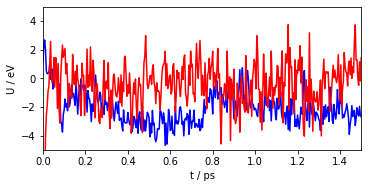

In [51]:
fig, ax = plt.subplots(1,1,constrained_layout=True, figsize=(5,2.5))
ax.plot(rpcmts_output["time"], (rpcmts_output["pot_component"]+rpcmts_output["pot_component+"])-
        (rpcmts_output["pot_component"]+rpcmts_output["pot_component+"])[10], 'b-', label="V / Å$^3$")
ax.plot(rpcmts_output["time"], rpcmts_output["pot_component++"]-rpcmts_output["pot_component++"][10], 'r-', label="V / Å$^3$")
ax.set_xlabel("t / ps")
ax.set_ylabel("U / eV")
ax.set_xlim(0,1.5)
ax.set_ylim(-5,5)

Simulations reach equilibrium faster than for the (weakly thermostatted) classical simulation, and even though the agreement between PIMD and the RPC+MTS run is not perfect, it is very good, in comparison with the major discrepancy between classical and quantum averages. 

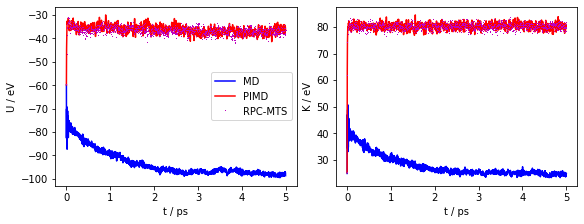

In [52]:
fig, ax = plt.subplots(1,2,constrained_layout=True, figsize=(8,3))
ax[0].plot(md_output["time"], md_output["potential"], 'b-', label="MD")
ax[0].plot(pimd_output["time"], pimd_output["potential"], 'r-', label="PIMD")
ax[0].plot(rpcmts_output["time"], rpcmts_output["potential"], 'm,', label="RPC-MTS")
ax[0].set_xlabel("t / ps")
ax[0].set_ylabel("U / eV")
ax[1].plot(md_output["time"], md_output["kinetic_md"], 'b-', label="MD")
ax[1].plot(pimd_output["time"], pimd_output["kinetic_cv"], 'r-', label="PIMD")
ax[1].plot(rpcmts_output["time"], rpcmts_output["kinetic_cv"], 'm,', label="RPC-MTS")
ax[1].set_xlabel("t / ps")
ax[1].set_ylabel("K / eV")
ax[0].legend();

RPC+MTS simulations generate a distribution of structures at the highest path integral resolution, and can be used to compute all sorts of structural properties.

In [53]:
# loads structures, discarding unused atom properties
warnings.filterwarnings('ignore', '.*residuenumbers array.*')
pi_frames = [ pimdmooc.read_ipi_xyz('rpc-mts.pos_'+str(i)+'.xyz') for i in range(8) ]
frames = []
for idx_f in range(len(pi_frames[0])):
    f = pi_frames[0][idx_f]
    for k in range(1,8):
        f += pi_frames[k][idx_f]
    f.info = {}
    f.arrays = {'positions': f.positions,  'numbers': f.numbers}
    frames.append(f)

In [54]:
chemiscope.show(frames=frames, 
                     properties={
                         "t" : { "values":  rpcmts_output["time"][::25], "units": "ps", "target":"structure"},
                         "U" : { "values":  rpcmts_output["potential"][::25], "units": "eV", "target":"structure"},
                         "K" : { "values":  rpcmts_output["kinetic_cv"][::25], "units": r"Å", "target":"structure"}
                     },
                     settings = {
                         'structure': [{ 'bonds': False, 
                                         'keepOrientation': True, 
                                         'unitCell': True,
                                         'playbackDelay': 20}],
                        'map': {'x': {'max': 5,  'min': 0, 'property': 't', 'scale': 'linear'},
                                'y': {'max': 3500,  'min': 2800, 'property': 'K', 'scale': 'linear'},
                                 'color': {'property': 'U'}
                               }
                     })

ChemiscopeWidget(value='{"meta": {"name": " "}, "settings": {"structure": [{"bonds": false, "keepOrientation":…